In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import json
import zlib
import warnings

warnings.filterwarnings("ignore")
sns.set_style("whitegrid")

BASE_DIR = Path("..")
INTERMEDIATE_DIR = BASE_DIR / "data" / "intermediate"

print("=" * 80)
print("COMPREHENSIVE INTERMEDIATE DATASET ANALYSIS")
print("=" * 80)

COMPREHENSIVE INTERMEDIATE DATASET ANALYSIS


In [5]:
print("\nLoading intermediate parquet files...")

parquet_files = sorted(INTERMEDIATE_DIR.glob("data_rank*.parquet"))
print(f"   Found {len(parquet_files)} files")

dfs = []
for pf in parquet_files:
    df = pd.read_parquet(pf)
    dfs.append(df)
    print(f"   {pf.name}: {len(df)} rows")

df_full = pd.concat(dfs, ignore_index=True)

print(f"\nTotal loaded: {len(df_full)} rows")
print(f"Columns: {list(df_full.columns)}")
print(f"Memory usage: {df_full.memory_usage(deep=True).sum() / (1024**2):.1f} MB")

print("\nDataset Info:")
print(f"Unique samples: {df_full['sample_id'].nunique()}")
print(f"Unique params: {df_full['param_id'].nunique()}")
print(f"Image shape (first): {df_full['image_shape'].iloc[0]}")


Loading intermediate parquet files...
   Found 8 files
   data_rank0000.parquet: 780 rows
   data_rank0001.parquet: 780 rows
   data_rank0002.parquet: 780 rows
   data_rank0003.parquet: 780 rows
   data_rank0004.parquet: 720 rows
   data_rank0005.parquet: 720 rows
   data_rank0006.parquet: 720 rows
   data_rank0007.parquet: 720 rows

Total loaded: 6000 rows
Columns: ['sample_id', 'param_id', 'image_compressed', 'image_shape', 'input_params', 'microstructure_outputs', 'performance_outputs']
Memory usage: 1215.3 MB

Dataset Info:
Unique samples: 100
Unique params: 60
Image shape (first): [128 128 128]


In [6]:
INPUT_FEATURES = [
    "input_SEI kinetic rate constant [m.s-1]",
    "input_Electrolyte diffusivity [m2.s-1]",
    "input_Initial concentration in electrolyte [mol.m-3]",
    "input_Separator porosity",
    "input_Positive particle radius [m]",
    "input_Negative particle radius [m]",
    "input_Positive electrode thickness [m]",
    "input_Negative electrode thickness [m]",
    "input_Outer SEI solvent diffusivity [m2.s-1]",
    "input_Dead lithium decay constant [s-1]",
    "input_Lithium plating kinetic rate constant [m.s-1]",
    "input_Negative electrode LAM constant proportional term [s-1]",
    "input_Negative electrode cracking rate",
    "input_Outer SEI partial molar volume [m3.mol-1]",
    "input_SEI growth activation energy [J.mol-1]",
]

MICROSTRUCTURE_FEATURES = [
    "D_eff",
    "porosity_measured",
    "tau_factor",
    "bruggeman_derived",
]

PERFORMANCE_FEATURES = [
    "nominal_capacity_Ah",
    "eol_cycle_measured",
    "initial_capacity_Ah",
    "final_capacity_Ah",
    "capacity_retention_percent",
    "total_cycles",
    "final_RUL",
]

input_arrays = np.array(df_full["input_params"].tolist())
df_inputs = pd.DataFrame(input_arrays, columns=INPUT_FEATURES)

micro_arrays = np.array(df_full["microstructure_outputs"].tolist())
df_micro = pd.DataFrame(micro_arrays, columns=MICROSTRUCTURE_FEATURES)

perf_arrays = np.array(df_full["performance_outputs"].tolist())
df_perf = pd.DataFrame(perf_arrays, columns=PERFORMANCE_FEATURES)

df_expanded = pd.concat(
    [
        df_full[["sample_id", "param_id"]].reset_index(drop=True),
        df_inputs,
        df_micro,
        df_perf,
    ],
    axis=1,
)

print(f"Expanded dataset shape: {df_expanded.shape}")
print(f"Total columns: {len(df_expanded.columns)}")

Expanded dataset shape: (6000, 28)
Total columns: 28


In [7]:
input_stats = df_inputs.describe().T
input_stats["missing"] = df_inputs.isnull().sum()
input_stats["missing_pct"] = (input_stats["missing"] / len(df_inputs) * 100).round(2)

cols = [
    "count",
    "mean",
    "std",
    "min",
    "25%",
    "50%",
    "75%",
    "max",
    "missing",
    "missing_pct",
]
input_stats = input_stats[cols]

print(input_stats.to_string())

missing_features = input_stats[input_stats["missing"] > 0]
constant_features = input_stats[input_stats["std"] == 0]

print("\nMissing features:")
print(missing_features[["missing", "missing_pct"]] if len(missing_features) else "None")

print("\nConstant features:")
print(constant_features[["mean"]] if len(constant_features) else "None")

                                                                count          mean           std           min           25%           50%           75%           max  missing  missing_pct
input_SEI kinetic rate constant [m.s-1]                        6000.0  4.955333e-14  4.013809e-14  1.000000e-14  1.000000e-14  3.090000e-14  1.000000e-13  1.000000e-13        0          0.0
input_Electrolyte diffusivity [m2.s-1]                         6000.0  3.001000e-10  5.789803e-11  2.000000e-10  2.515000e-10  3.010000e-10  3.497500e-10  3.980000e-10        0          0.0
input_Initial concentration in electrolyte [mol.m-3]           6000.0  1.000000e+03  0.000000e+00  1.000000e+03  1.000000e+03  1.000000e+03  1.000000e+03  1.000000e+03        0          0.0
input_Separator porosity                                       6000.0  5.870974e-01  2.892336e-02  5.380924e-01  5.628673e-01  5.867180e-01  6.123321e-01  6.363797e-01        0          0.0
input_Positive particle radius [m]                

In [8]:
micro_stats = df_micro.describe().T
micro_stats["missing"] = df_micro.isnull().sum()
micro_stats["missing_pct"] = (micro_stats["missing"] / len(df_micro) * 100).round(2)
micro_stats = micro_stats[cols]

print(micro_stats.to_string())

print("\nMicrostructure correlation matrix:")
print(df_micro.corr().to_string())

                    count         mean           std            min       25%       50%       75%        max  missing  missing_pct
D_eff              6000.0     0.169028      0.089880      -0.000001  0.096046  0.163874  0.243770   0.440176        0          0.0
porosity_measured  6000.0     0.481076      0.074871       0.316413  0.422592  0.476487  0.539763   0.652044        0          0.0
tau_factor         6000.0 -3130.721328  31190.511773 -313446.531250  2.331789  2.945959  4.379449  15.862245        0          0.0
bruggeman_derived  6000.0     1.595999      0.025056       1.400000  1.600000  1.600000  1.600000   1.600000        0          0.0

Microstructure correlation matrix:
                      D_eff  porosity_measured  tau_factor  bruggeman_derived
D_eff              1.000000           0.828141    0.188967          -0.044141
porosity_measured  0.828141           1.000000    0.084631           0.021658
tau_factor         0.188967           0.084631    1.000000           0.7862

In [9]:
perf_stats = df_perf.describe().T
perf_stats["missing"] = df_perf.isnull().sum()
perf_stats["missing_pct"] = (perf_stats["missing"] / len(df_perf) * 100).round(2)
perf_stats = perf_stats[cols]

print(perf_stats.to_string())

retention = df_perf["capacity_retention_percent"].dropna()
cycles = df_perf["total_cycles"].dropna()
eol_cycles = df_perf["eol_cycle_measured"].dropna()
nominal_cap = df_perf["nominal_capacity_Ah"].dropna()
rul = df_perf["final_RUL"].dropna()

print("\nRetention summary:")
print(retention.describe())

print("\nCycle summary:")
print(f"Mean total cycles: {cycles.mean():.1f}")
print(f"Mean EOL cycles: {eol_cycles.mean():.1f}")

print("\nCapacity summary:")
print(f"Mean nominal capacity: {nominal_cap.mean():.3f} Ah")

print("\nRUL summary:")
print(f"Mean final RUL: {rul.mean():.1f}")
print(f"Max RUL: {rul.max():.1f}")

                             count       mean        std        min        25%        50%        75%         max  missing  missing_pct
nominal_capacity_Ah         5899.0   5.000000   0.000000   5.000000   5.000000   5.000000   5.000000    5.000000      101         1.68
eol_cycle_measured          2520.0  23.296032  21.349575   1.000000   6.000000  18.000000  34.000000  100.000000     3480        58.00
initial_capacity_Ah         5899.0   5.446203   0.931357   2.916068   4.726835   5.462853   6.152777    8.028255      101         1.68
final_capacity_Ah           5899.0   4.125667   0.751643   2.091535   3.553835   4.158381   4.706125    6.206268      101         1.68
capacity_retention_percent  5899.0  75.592187   1.492596  69.682608  74.892807  75.823249  76.519325   78.209538      101         1.68
total_cycles                6000.0  53.743000  25.004703   0.000000  31.000000  47.000000  75.000000  117.000000        0         0.00
final_RUL                   5899.0  20.216382  26.01586

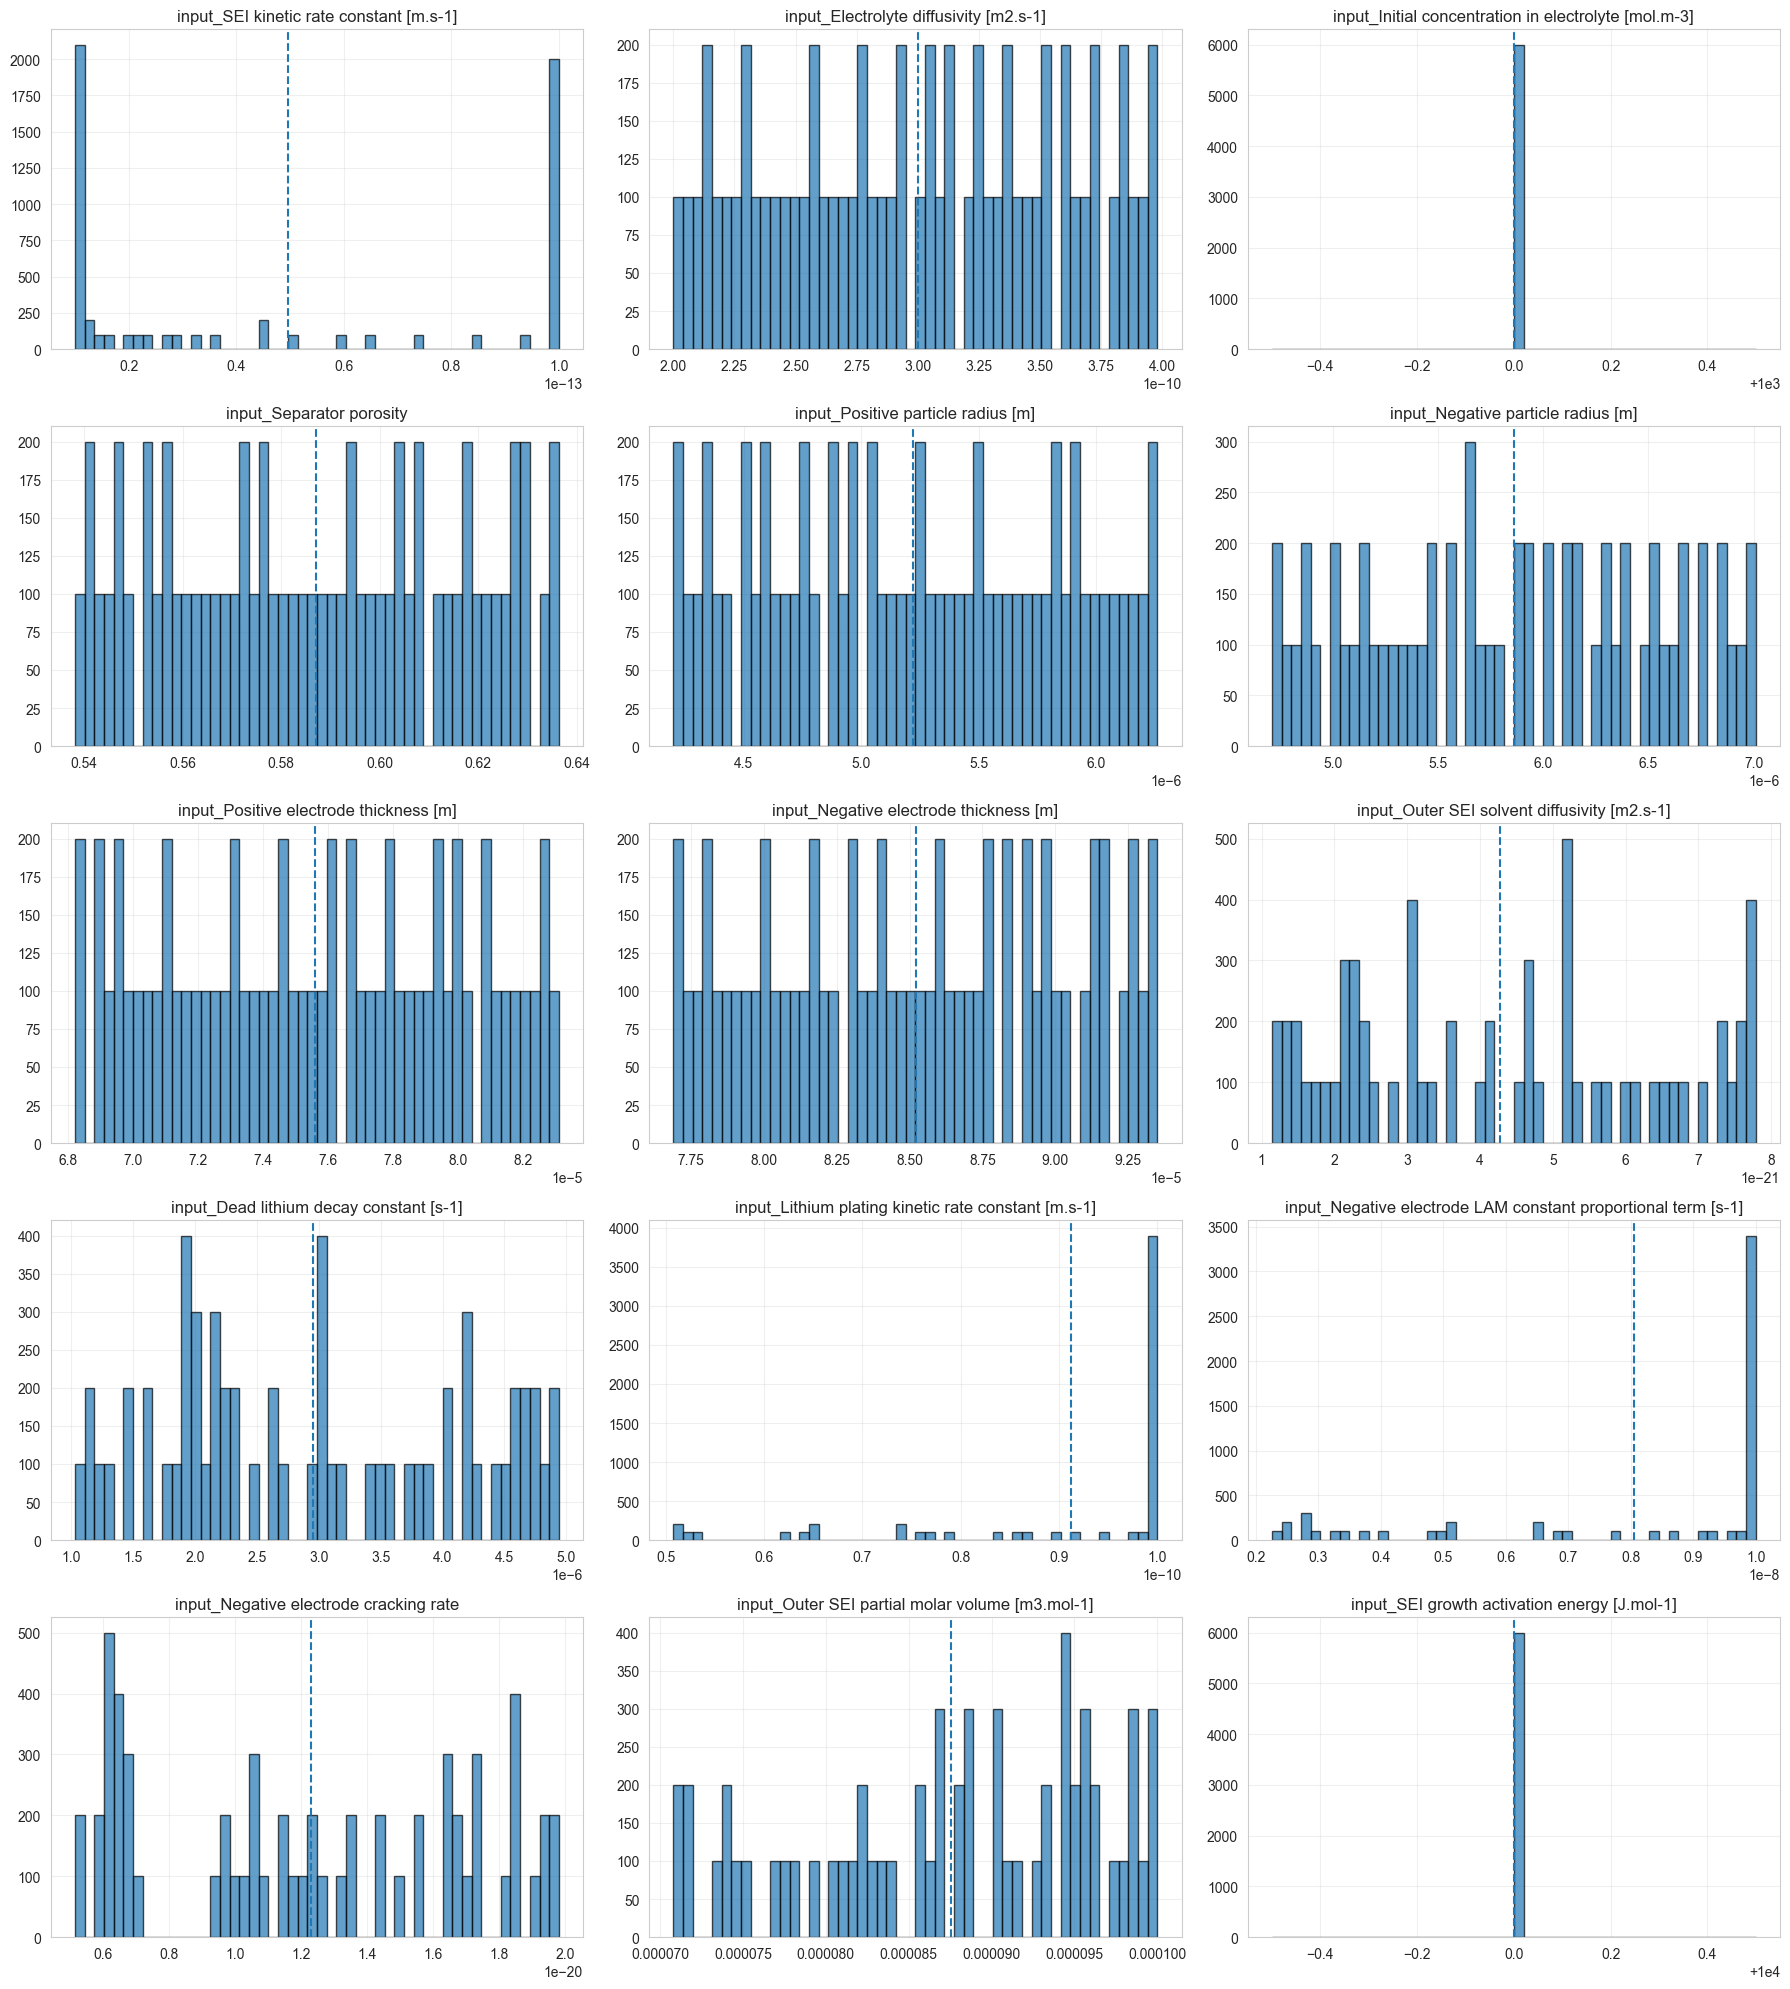

In [10]:
n_features = len(INPUT_FEATURES)
n_cols = 3
n_rows = (n_features + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 4 * n_rows))
axes = axes.flatten()

for idx, feat in enumerate(INPUT_FEATURES):
    data = df_inputs[feat].dropna()
    ax = axes[idx]
    ax.hist(data, bins=50, alpha=0.7, edgecolor="black")
    ax.axvline(data.mean(), linestyle="--")
    ax.set_title(feat)
    ax.grid(True, alpha=0.3)

for idx in range(n_features, len(axes)):
    axes[idx].axis("off")

plt.tight_layout()
plt.show()

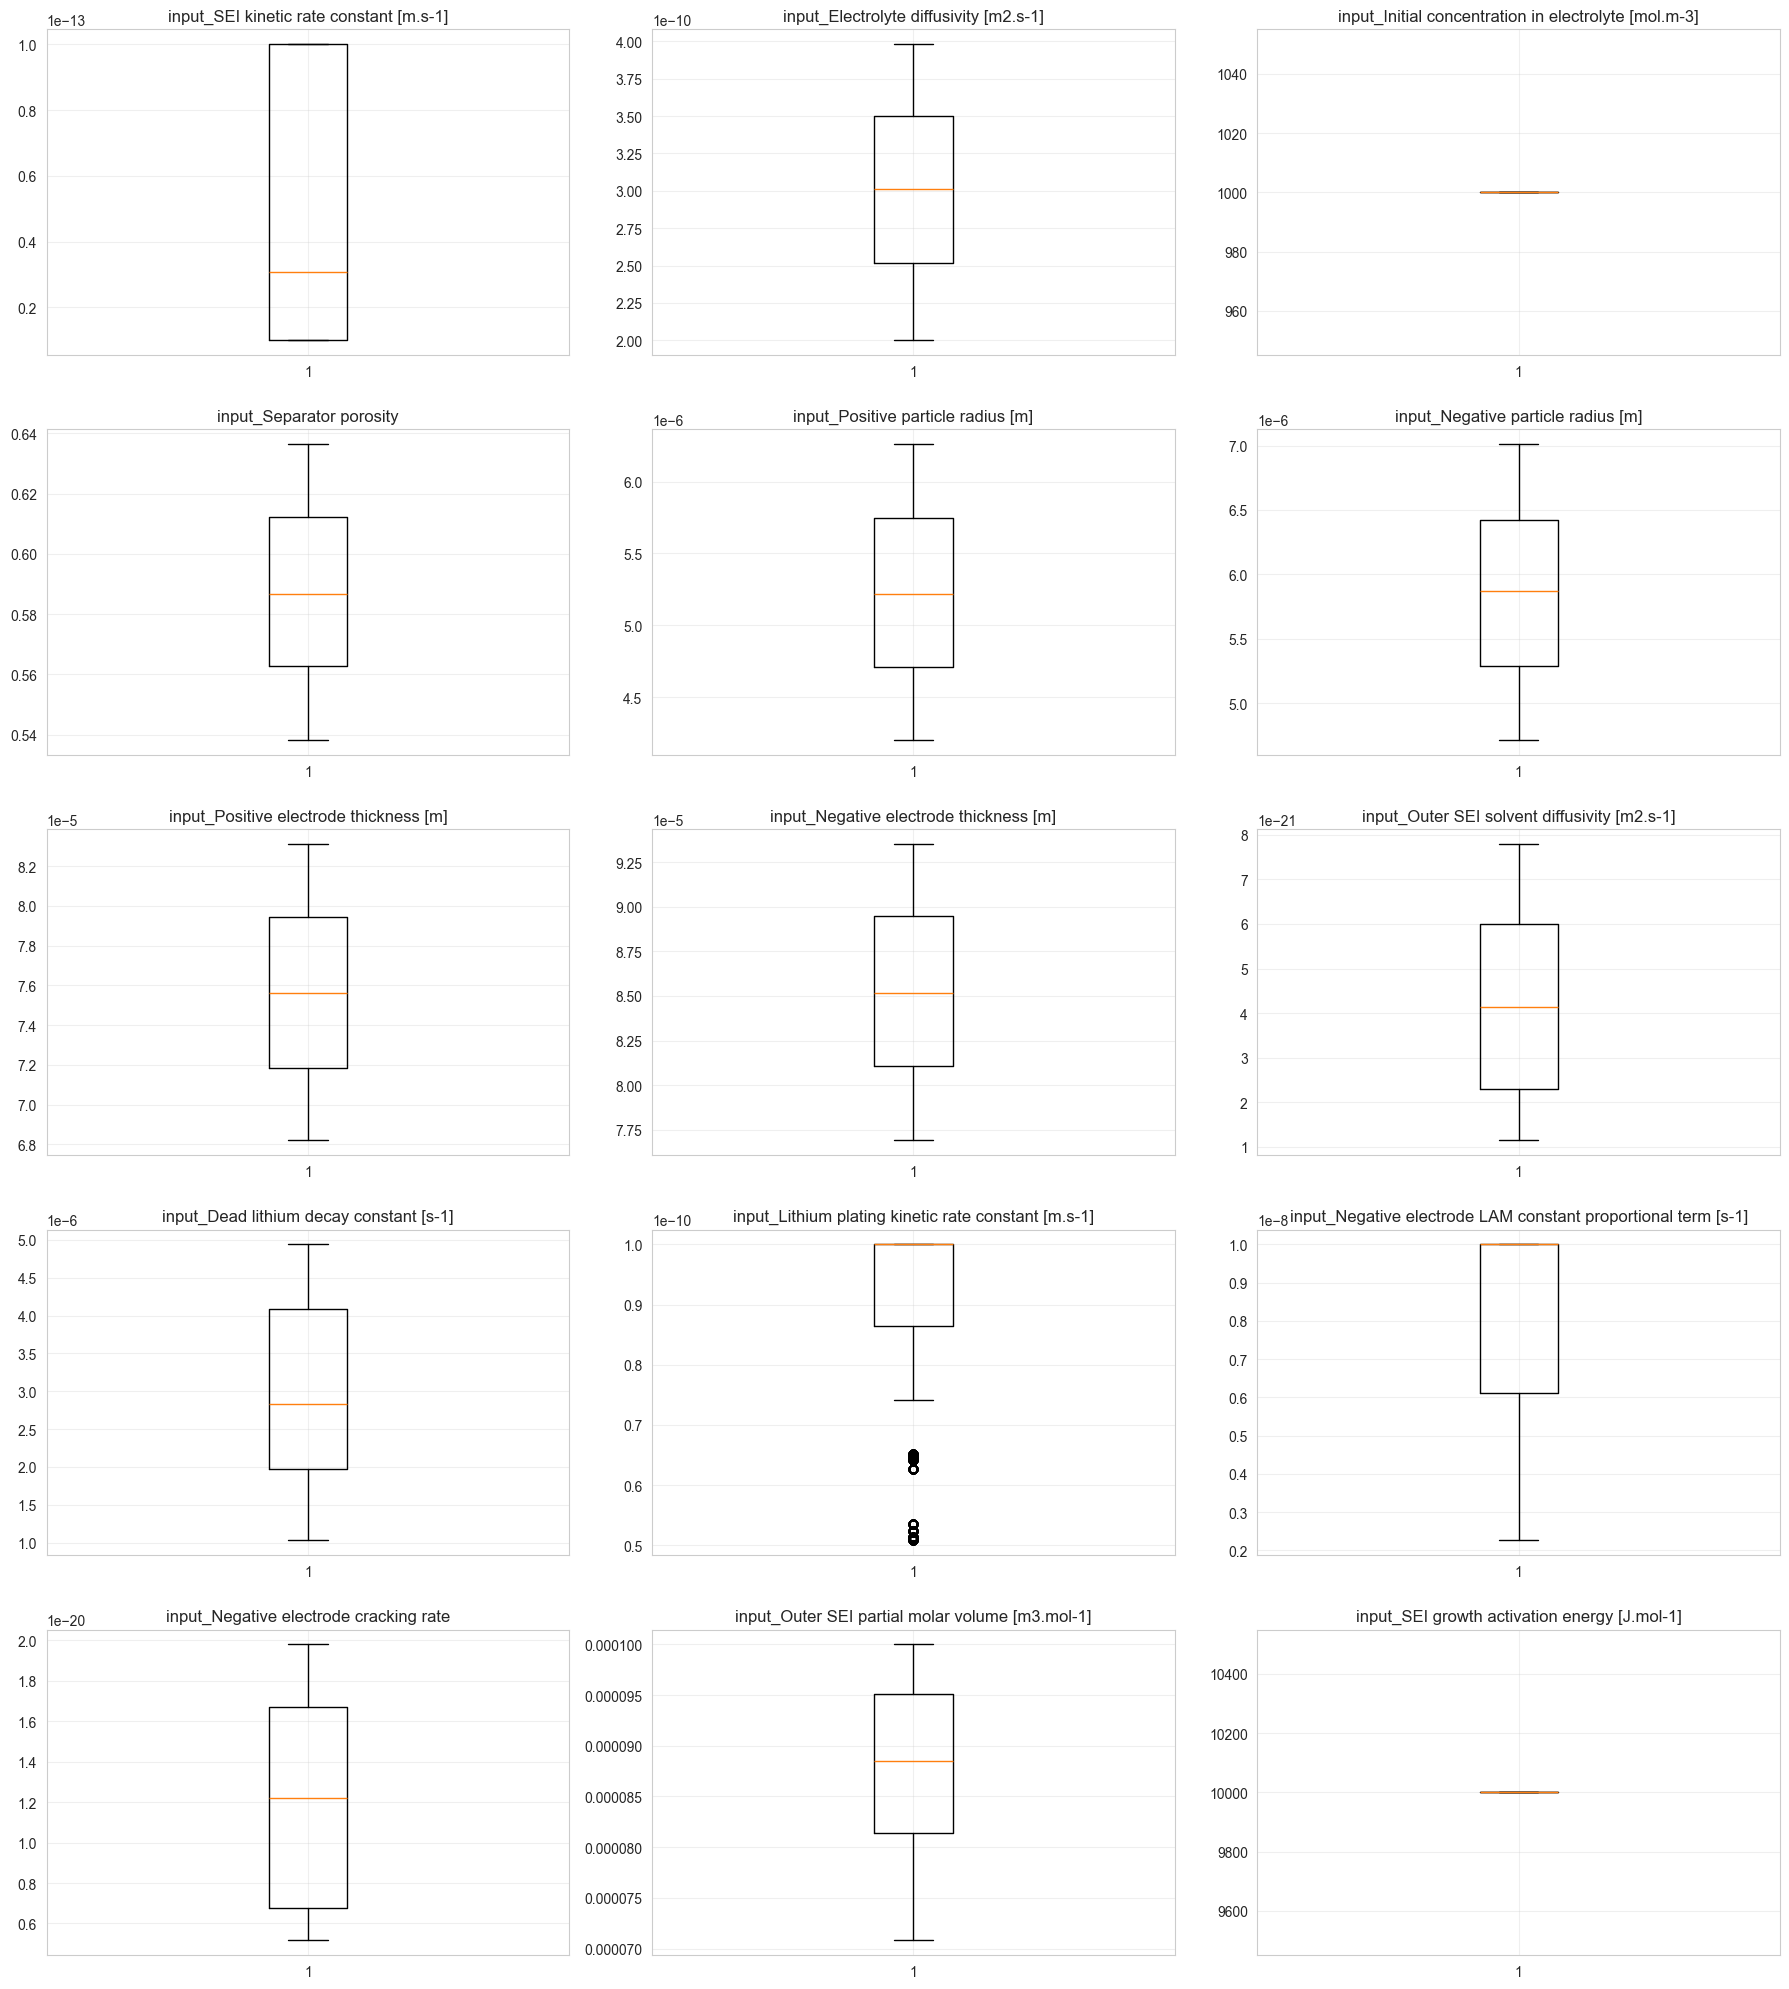

In [11]:
fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 4 * n_rows))
axes = axes.flatten()

for idx, feat in enumerate(INPUT_FEATURES):
    data = df_inputs[feat].dropna()
    ax = axes[idx]
    ax.boxplot(data, vert=True)
    ax.set_title(feat)
    ax.grid(True, alpha=0.3)

for idx in range(n_features, len(axes)):
    axes[idx].axis("off")

plt.tight_layout()
plt.show()

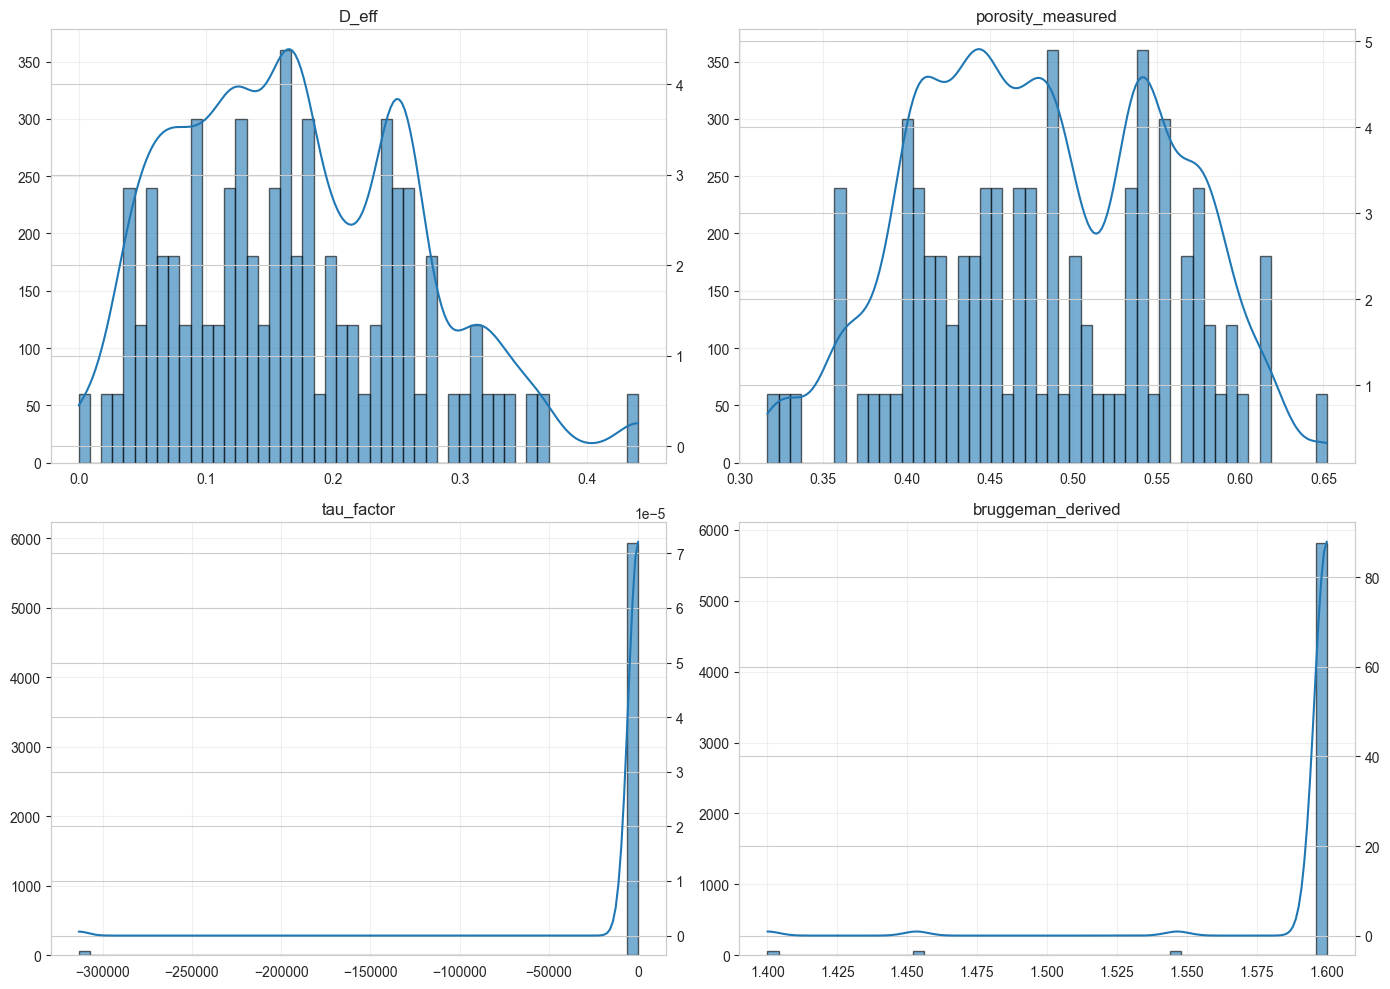

In [12]:
from scipy import stats

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for idx, feat in enumerate(MICROSTRUCTURE_FEATURES):
    data = df_micro[feat].dropna()
    ax = axes[idx]
    ax.hist(data, bins=50, alpha=0.6, edgecolor="black")

    density = stats.gaussian_kde(data)
    xs = np.linspace(data.min(), data.max(), 200)
    ax2 = ax.twinx()
    ax2.plot(xs, density(xs))

    ax.set_title(feat)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

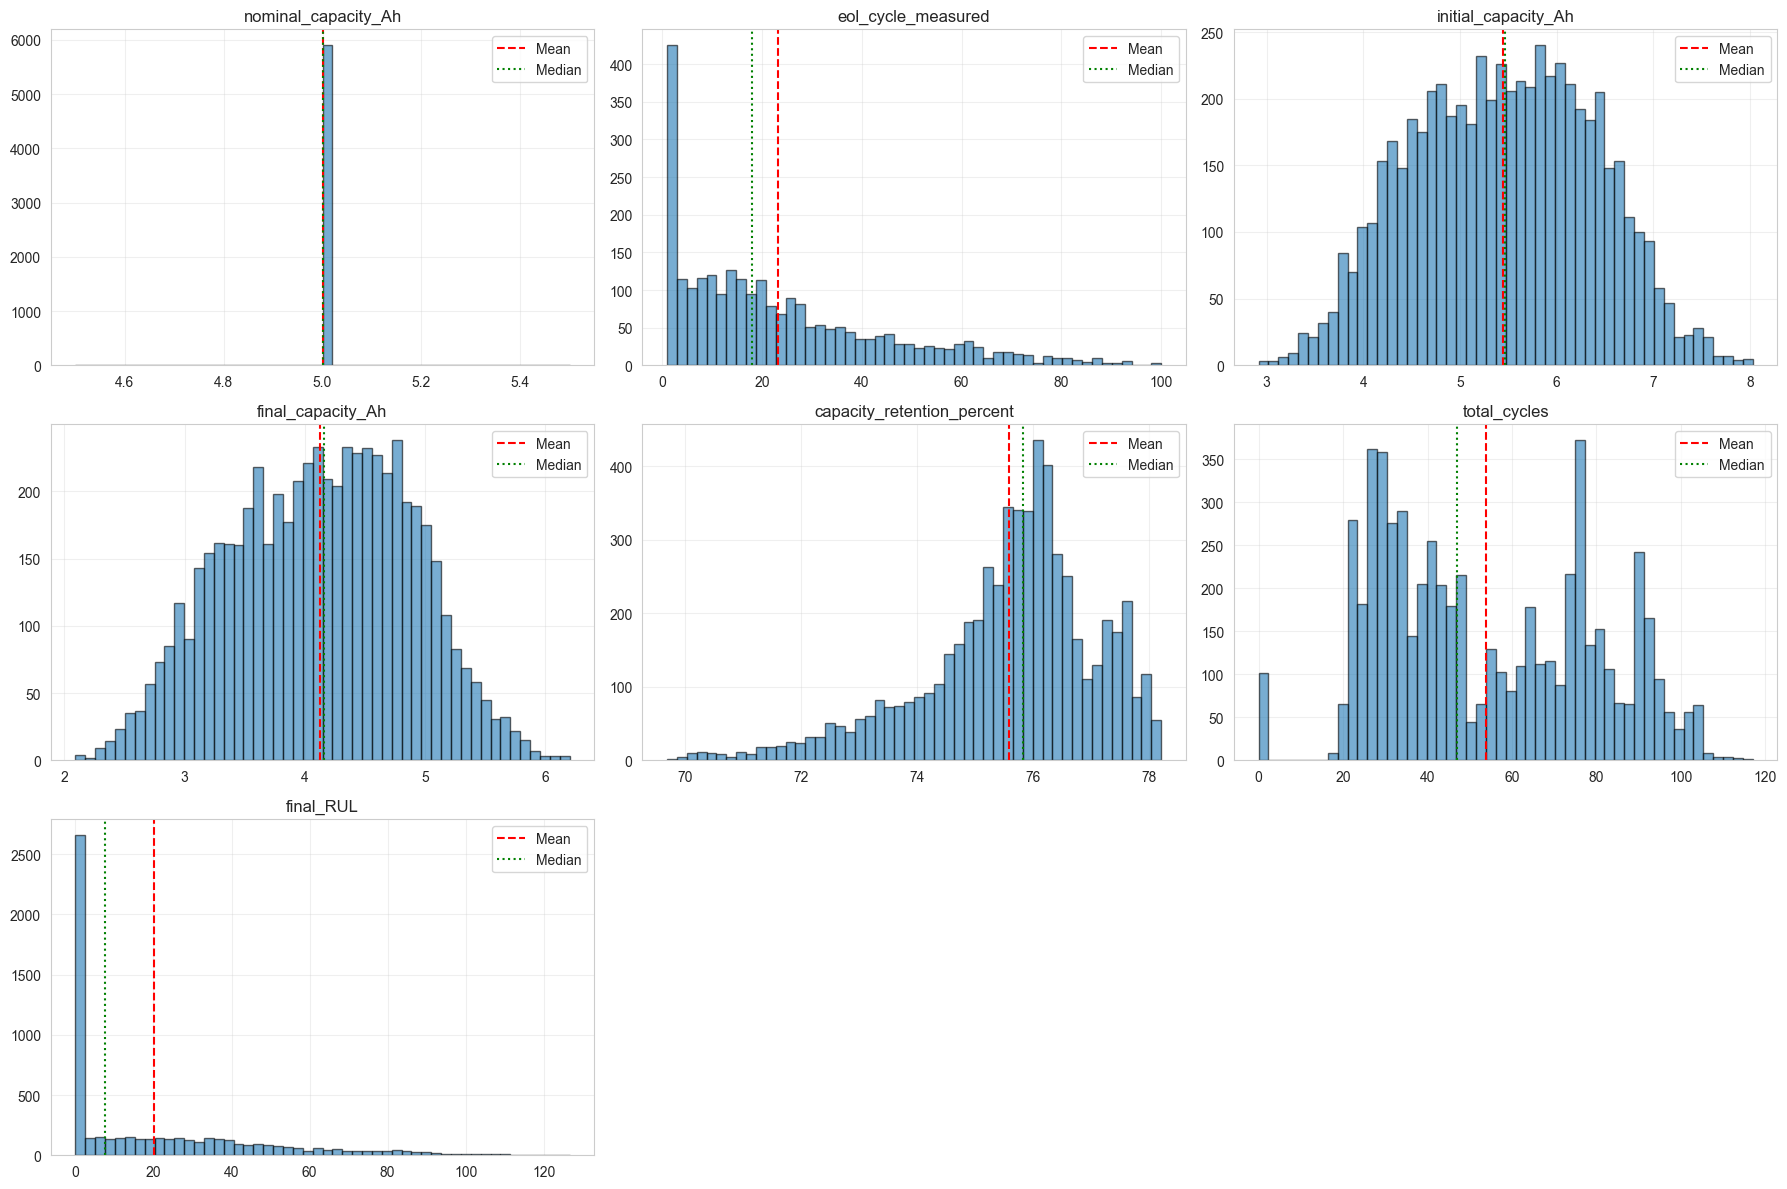

In [13]:
n_perf = len(PERFORMANCE_FEATURES)
n_cols = 3
n_rows = (n_perf + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 4 * n_rows))
axes = axes.flatten()

for idx, feat in enumerate(PERFORMANCE_FEATURES):
    ax = axes[idx]
    data = df_perf[feat].dropna()
    if len(data) == 0:
        ax.set_title(f"{feat} (no data)")
        continue
    ax.hist(data, bins=50, alpha=0.6, edgecolor="black")
    ax.axvline(data.mean(), color="red", linestyle="--", label="Mean")
    ax.axvline(data.median(), color="green", linestyle=":", label="Median")
    ax.set_title(feat)
    ax.legend()
    ax.grid(True, alpha=0.3)

for idx in range(n_perf, len(axes)):
    axes[idx].axis("off")

plt.tight_layout()
plt.show()

In [14]:
summary = {
    "dataset": {
        "total_rows": len(df_expanded),
        "unique_samples": int(df_expanded["sample_id"].nunique()),
        "unique_params": int(df_expanded["param_id"].nunique()),
    }
}

summary_file = BASE_DIR / "data" / "intermediate_analysis_summary.json"
with open(summary_file, "w") as f:
    json.dump(summary, f, indent=2)

sample_file = BASE_DIR / "data" / "intermediate_sample.csv"
df_expanded.head(100).to_csv(sample_file, index=False)

print("Analysis complete.")

Analysis complete.
